In [1]:
    # importing required libraries
import random
import simpy
import queue
import math
import pandas as pd
import numpy as np
from collections import defaultdict, namedtuple
import matplotlib.pyplot as plt

In [2]:
RANDOM_SEED = 42    # for repeatability
NUM_LOADERS = 1     # Number of chairs that can be loaded at once
NUM_CHAIRS = 100     # Number of chairs on the ski lift
LOADTIME = 0        # Setting to zero to make load times instantaneous
CHAIR_CAP = 3       # Number of passengers each chair can take
TRIPTIME = 5       # Minutes it takes for the chair to drop off riders and return to bottom of mountain
T_INTER = 5         # interarrival times for groups
SIM_TIME = 480      # 8 hours of simulation run time

# variables for MONITORING
MAX_GROUP_ARRIVALS = 5
GROUP_SIZES = []
group_event = namedtuple("group_event", "time name size event_type") # event type = arrive, load
queue_event = namedtuple("queue_event", "time queue_size")
chair_event = namedtuple("chair_event", "time chair rider_count")

In [3]:
class Chair(object):
    def __init__(self, env, capacity, triptime, n_riders, chair_id):
        self.env = env
        self.capacity = capacity
        self.resource = simpy.Resource(env, capacity)
        self.triptime = triptime
        self.n_riders = n_riders
        self.chair_id = chair_id

    def accept_rider(self):
        self.n_riders += 1
        
    def dropoff_riders(self):
        yield self.env.timeout(TRIPTIME/2)
        
        # reset to zero after dropping off riders
        self.n_riders = 0
        
    def return_to_pickup(self, ski_lift):
        yield self.env.timeout(TRIPTIME/2)
        
        # add back to queue
        ski_lift.put(self)


In [4]:
# Only one group can load at a time    
class LoadingPlatform(object):
    def __init__(self, env, capacity):
        self.env = env
        self.capacity = capacity
        self.resource = simpy.Resource(env, capacity)
    
    def load(self):
        yield self.env.timeout(LOADTIME)

In [5]:
# defines a single rider differently than the group
class SingleRider(object):
    def __init__(self, name):
        self.name=name

In [6]:
def group(env, name, size, ski_lift, loader, single_rider_line, data):
    """Each group arrives at the ski lift line and will take up size/3 chairs (+1 if remainder != 0)
       If single rider is being used and queue length > 0, single riders will be placed in empty chairs
            after the group is done being loaded
    """
    
    #print(f"Group {name} of size {size} arrived at line at time {env.now}")
        # add group arrival time for monitoring
    data['group_data'].append(group_event(env.now, name, size, 'arrival'))
    
    num_chairs = math.ceil(size/CHAIR_CAP)
    left_to_load = size
    
    i = 0
        # group requests to be loaded by joining the queue
    with loader.resource.request() as loader_request:
        yield loader_request
        data['queue_data'].append(queue_event(env.now, len(loader.resource.queue)))
        data['group_data'].append(group_event(env.now, name, size, 'start_load'))
        
        for ch in range(num_chairs):
            load_chair = ski_lift.get()
            
                # while chair has capacitiy and riders in the group still need to be loaded, add rider(s)
            while load_chair.n_riders < load_chair.capacity and left_to_load > 0:
                load_chair.accept_rider()
                
                #print(f"Skiier {i+1} from group {name} got on chair {load_chair.chair_id} at time {env.now}")
                left_to_load -=1
                i+=1
            
                # if single rider line input parameter is true, then execute single rider logic
            if USE_SINGLE_RIDER:
                for j in range(2):
                    if load_chair.n_riders < load_chair.capacity and not single_rider_line.empty():
                        single_rider = single_rider_line.get()
                        load_chair.accept_rider()
                        data['group_data'].append(group_event(env.now, single_rider.name, 1, 'start_load'))
                        data['group_data'].append(group_event(env.now, single_rider.name, 1, 'end_load'))
                        #print(f"Single skiier from group {single_rider.name} got on chair {load_chair.chair_id} at time {env.now}")
            
                # once chair is full (or there are no riders left to load), send it
            with load_chair.resource.request() as chair_request:

                yield chair_request
                data['group_data'].append(group_event(env.now, name, size, 'end_load'))
                data['capacity_data'].append(chair_event(env.now, load_chair.chair_id, load_chair.n_riders))

                yield env.process(load_chair.dropoff_riders())
                yield env.process(load_chair.return_to_pickup(ski_lift))
                

        yield env.process(loader.load())
        #print(f"Chair {load_chair.chair_id} fully loaded at time {env.now}")


In [7]:
def setup(env, num_chairs, triptime, t_inter, data):
    # create ski lift from a bunch of chairs
    ski_lift = queue.Queue()
    for i in range(NUM_CHAIRS):
        ski_lift.put(Chair(env, CHAIR_CAP, TRIPTIME, 0, i+1))
    
    if USE_SINGLE_RIDER:
        single_rider_line = queue.Queue()
    else:
        single_rider_line = None

    loader = LoadingPlatform(env, NUM_LOADERS)
    
    i=0
            # very first group size set to be not a single rider
    group_size = math.ceil(random.triangular(low = 1, high = MAX_GROUP_ARRIVALS, mode = 2))
            
    env.process(group(env, i+1, group_size, ski_lift, loader, single_rider_line, data))
    i+=1
    
    while True:
            # interarrival time is exponential with mean set as t_inter (= 5 mins)
        yield env.timeout(np.random.exponential(scale = t_inter))
            # group size is triangular between 1 and max size (= 8) with highest frequency at 2
        group_size = math.ceil(random.triangular(low = 0, high = MAX_GROUP_ARRIVALS, mode = 2))
        
            # single riders are treated as different entity types
        if group_size == 1 and USE_SINGLE_RIDER:
            #print(f"Group {i+1} of size {group_size} arrived at line at time {env.now}")
            data['group_data'].append(group_event(env.now, i+1, group_size, 'arrival'))

            single_rider_line.put(SingleRider(i+1))

        else:
            env.process(group(env, i+1, group_size, ski_lift, loader, single_rider_line, data))
        GROUP_SIZES.append(group_size)
        i += 1


In [8]:
def calc_stats(data):
    '''
    Function to calculate relevant metrics for each simulation as SimPy does not natively provide capabilities to do so
    '''
    # calc throughput and avg wait time
    group_df = pd.DataFrame(data['group_data']).groupby(['name','size', 'event_type']).agg({'time':'max'}).reset_index()
    group_df = group_df.pivot(index=['name', 'size'], columns='event_type', values='time').reset_index()
    group_df['wait_time'] = group_df.start_load - group_df.arrival
    throughput = group_df.loc[~(group_df.end_load.isnull())].size.sum()
    avg_wait = group_df.loc[~(group_df.start_load.isnull())].wait_time.mean()
    
    # calc chair utilization 
    utilization = pd.DataFrame(data['capacity_data']).rider_count.mean()
    
    # calc avg queue length
    qd = pd.DataFrame(data['queue_data'])
    qd['change_time'] = qd.time.shift(-1)
    qd['time_length'] = qd.change_time - qd.time
    qd['value'] = qd.queue_size * qd.time_length
    avg_queue_length = qd.value.sum()/qd.time.max()
    
    return throughput, avg_wait, utilization, avg_queue_length


In [9]:
def run(USE_SINGLE_RIDER, output_data):
    
        # initialize dictionary to keep track of data for each run
    daily_data = defaultdict(list)
    
    env = simpy.Environment()
    
    env.process(setup(env, NUM_CHAIRS, TRIPTIME, T_INTER, daily_data))
    
    env.run(until=SIM_TIME)
    
        # using calculations defined above to output a summary for that simulation run
    output_data.append(calc_stats(daily_data))

In [10]:
random.seed(RANDOM_SEED)
    
data_with_sr = [] # initialize list that will store tuple output for each run

USE_SINGLE_RIDER = True

i = 0
    # run simulation with single rider line for a 1000 times
while i < 1000:
    run(USE_SINGLE_RIDER, data_with_sr)
    i += 1

        # create dataframe with output metrics
df_with_sr = pd.DataFrame(data = data_with_sr, 
                          columns = ['throughput', 'avg_wait', 'utilization', 'avg_queue_length']
                         )


# below for no single rider

#reset random seed for comparable results
random.seed(RANDOM_SEED)
data_no_sr = []

USE_SINGLE_RIDER = False
i = 0
    # run simulation without single rider line for a 1000 times
while i < 1000:
    run(USE_SINGLE_RIDER, data_no_sr)
    i += 1
    
df_no_sr = pd.DataFrame(data = data_no_sr, 
                          columns = ['throughput', 'avg_wait', 'utilization', 'avg_queue_length']
                         )

In [11]:
# output average for each metric to include in final report
df_with_sr.mean()

throughput          489.462000
avg_wait             40.426264
utilization           2.446331
avg_queue_length      7.701045
dtype: float64

In [12]:
df_no_sr.mean()

throughput          448.668000
avg_wait             57.121597
utilization           2.240725
avg_queue_length     11.070836
dtype: float64

In [13]:
# function to generate histogram for each metric    
def generate_histogram(column_nm, x_axis_label, title, pic_title):
    sr_t = np.array(df_with_sr[column_nm])
    no_sr_t = np.array(df_no_sr[column_nm])

    fig, axs = plt.subplots(1,1, tight_layout = True)

    axs.hist(sr_t, alpha = .5, bins = 20, label = 'Single Rider Line')
    axs.hist(no_sr_t, alpha = .5, bins = 20, label = 'No Single Rider Line')

    plt.xlabel(x_axis_label)
    plt.ylabel('Frequency')
    plt.title(title)

    axs.legend()
    
    plt.savefig(pic_title)

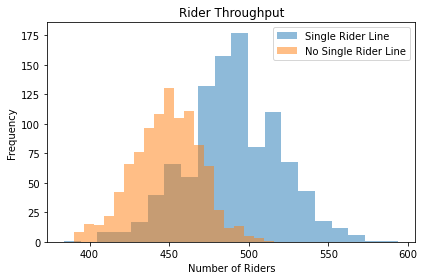

In [14]:
generate_histogram('throughput', 'Number of Riders', 'Rider Throughput', 'throughput.png')

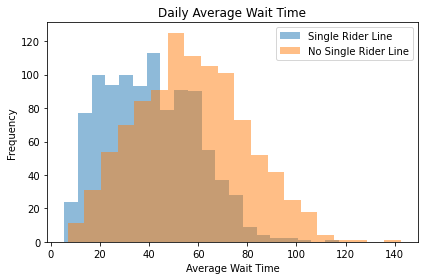

In [15]:
generate_histogram('avg_wait', 'Average Wait Time', 'Daily Average Wait Time', 'avg_wait_time.png')

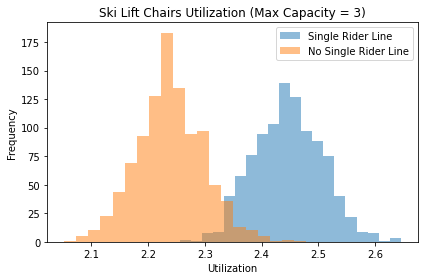

In [16]:
generate_histogram('utilization', 'Utilization', 'Ski Lift Chairs Utilization (Max Capacity = 3)', 
                   'utilization.png')

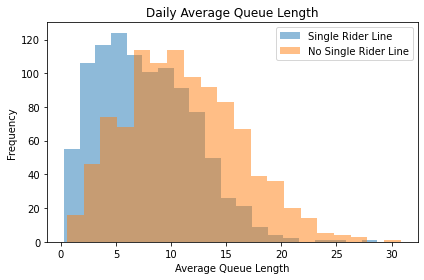

In [17]:
generate_histogram('avg_queue_length', 'Average Queue Length', 'Daily Average Queue Length', 'avg_queue_len.png')